<a href="https://colab.research.google.com/github/swilsonmfc/stable-diffusion/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks

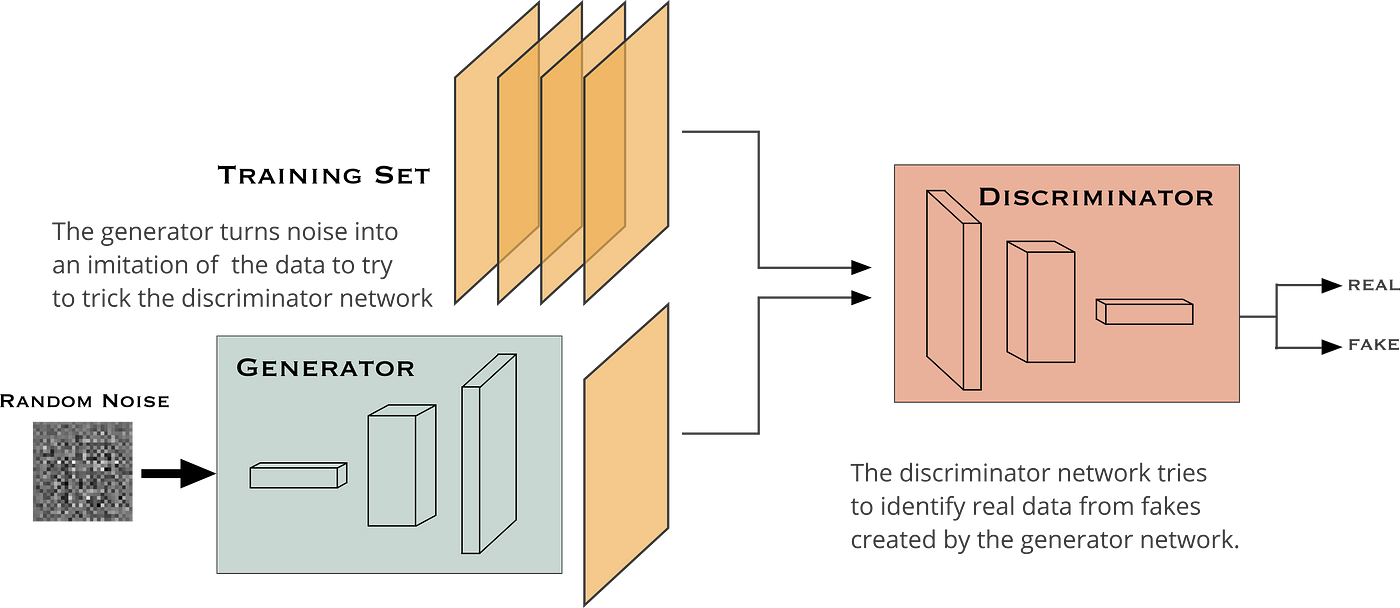

# Install

# Setup

In [1]:
import glob
import time
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from IPython import display

import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.utils import plot_model

# Parameters

In [2]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
NOISE_DIM = 100
LEARNING_RATE = 1e-4

# Load Data

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Activation - LeakyReLU

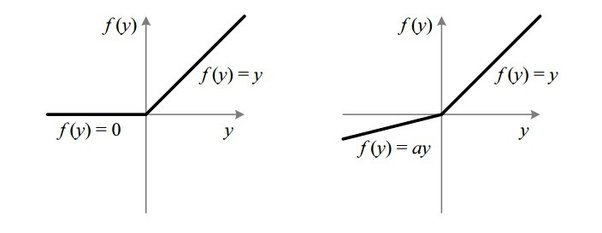

# Generator

In [5]:
def generator_model():
    model = Sequential()
    model.add(Dense(7 * 7 * 256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [6]:
generator = generator_model()

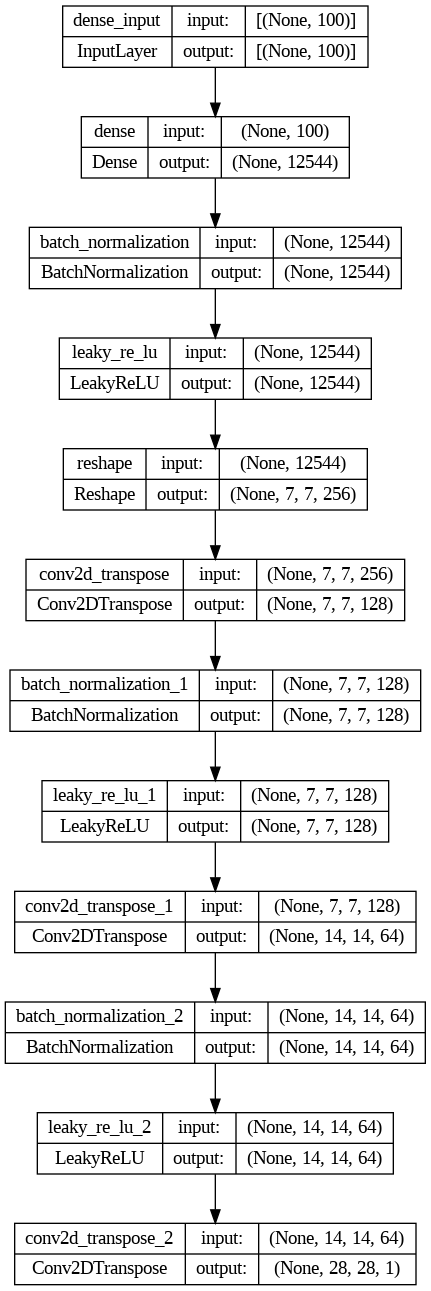

In [7]:
plot_model(generator, show_shapes=True)

# Discriminator

In [8]:
def discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [9]:
discriminator = discriminator_model()

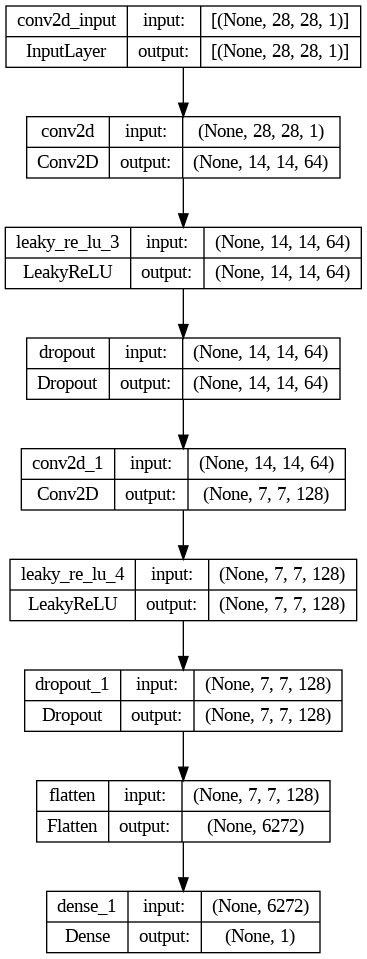

In [10]:
plot_model(discriminator, show_shapes=True)

# Example - Before Training

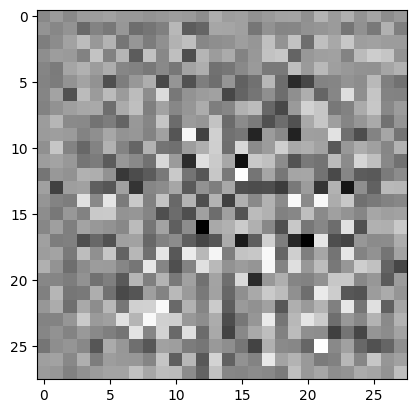

In [11]:
noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [12]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00181656]], shape=(1, 1), dtype=float32)


# Cross-Entropy Loss

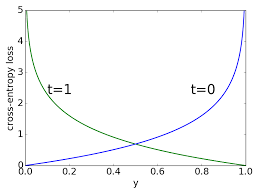

In [13]:
cross_entropy = BinaryCrossentropy(from_logits = True)

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Adam Optimizer

In [16]:
generator_optimizer = Adam(LEARNING_RATE)
discriminator_optimizer = Adam(LEARNING_RATE)

# Training

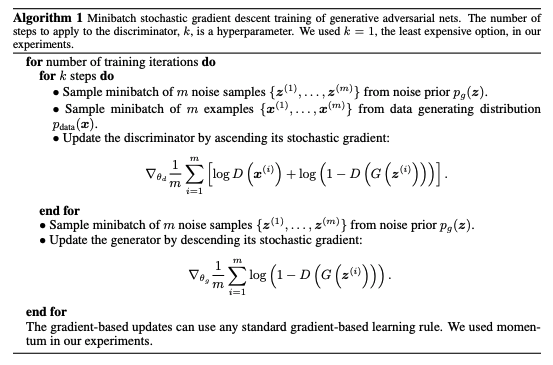

In [17]:
EPOCHS = 50
EXAMPLES = 16

seed = tf.random.normal([EXAMPLES, NOISE_DIM])

In [18]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Run
* Update the images generated after each epoch!

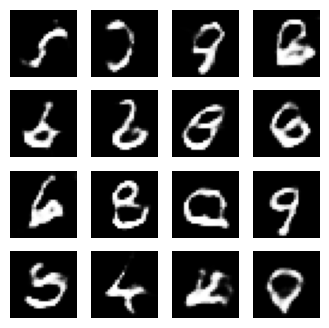

In [21]:
train(train_dataset, EPOCHS)

# Example - After Training

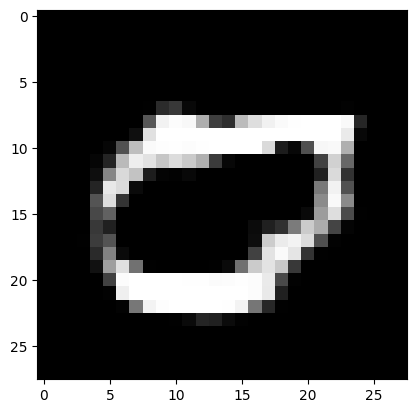

In [22]:
noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [23]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.78338444]], shape=(1, 1), dtype=float32)


# Loss / Accuracy Plots
* https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

## Healthy GAN

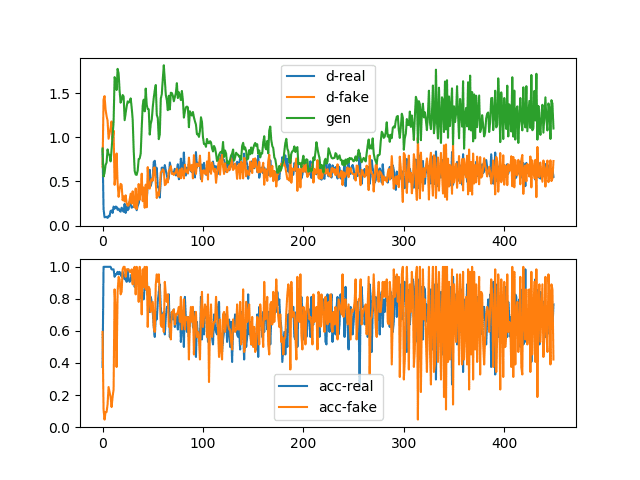

## Mode Collapse
* Generator creates identical output over the latent space

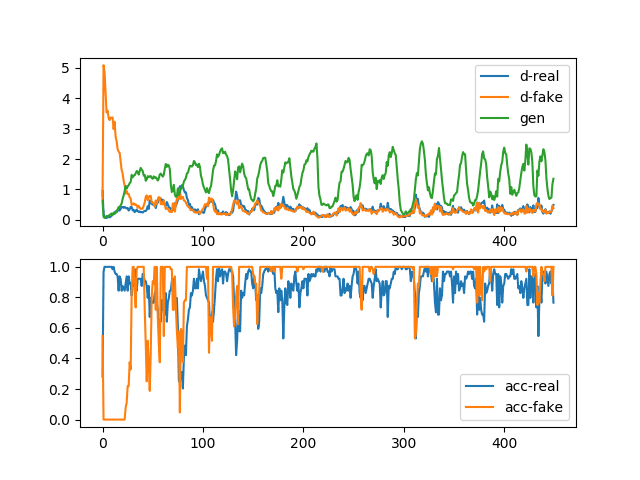

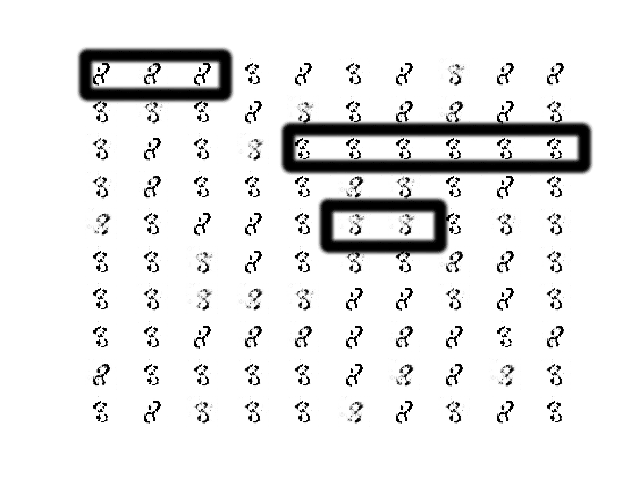

## Failing to Converge
* Learning Rate too High
* Generator outputs noise, very easy for discriminator
* Expected behavior in early stages, but we should see improvement

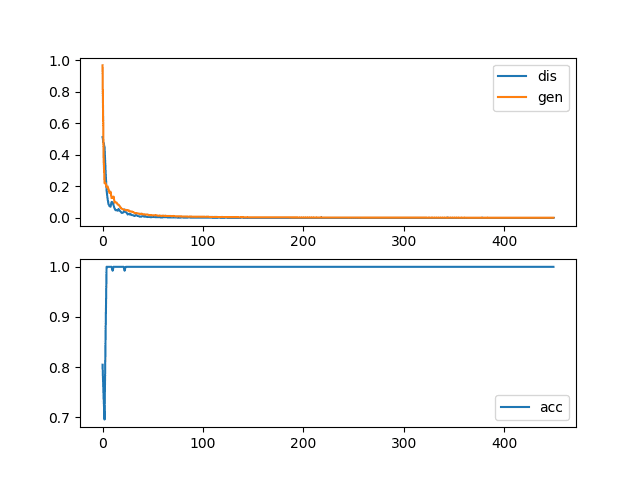

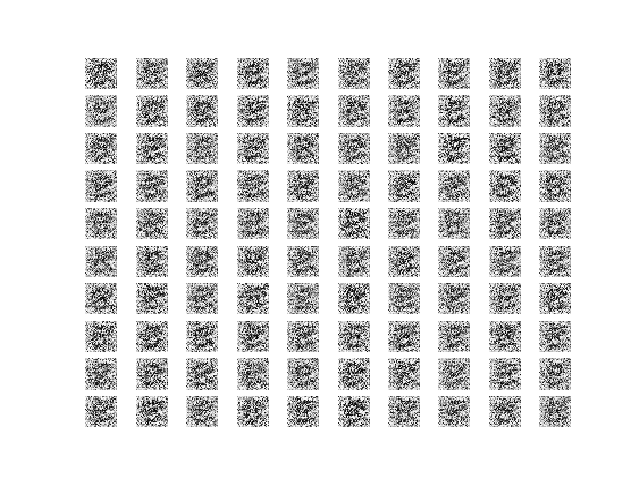

# Best Practices
* Network
  * Adam Optimizer
  * BatchNormalization Layers
  * Leaky ReLU
* Strided Convolutions 
  * Downsample - Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', )
  * Upsample - Conv2DTranspose(64, kernel_size=(4,4), strides=(2,2), padding='same', ...)
* Increase Discriminator Challenge
  * LabelSmoothing - Random noise around positive "real" images
  * Noisy Labels - Randomly flip real - fake
* Loss functions & Architectures for Mode Collapse / Covergence
  * Wasserstein GAN
  * Pro GAN